# How to rediscover the Higgs boson yourself!
This notebook uses the new release of ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

The idea is that cuts increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, the amount of $Z$ and $t\bar{t}$ background is reduced, since these are quite different to the signal.

Then, the amount of $ZZ \rightarrow \ell\ell\ell\ell$ is reduced, whilst keeping as much $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal as possible.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This analysis loosely follows the [Measurement of inclusive and differential cross sections in the H->ZZ*->4l decay channel in pp collisions at $\sqrt{s} = 13~$TeV with the ATLAS detector](https://link.springer.com/article/10.1007/JHEP10(2017)132)

By the end of this notebook you will be able to:
1. rediscover the Higgs boson yourself!
2. know some general principles of a particle physics analysis

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="../uproot_python/images/feynman_diagrams/HZZ_feynman.png" style="width:40%"></CENTER>

In [1]:
import ROOT
import glob
import os
%jsroot on
ROOT.gStyle.SetOptStat(0);

Welcome to JupyROOT 6.30/04


We have some functions in C++ which we will use later. Need to compile these so that we can ause them in RDataFrame

In [2]:
! g++ -shared -fPIC -o ./helperFunctions.so ./helperFunctions.cxx `root-config --cflags --glibs`

In [3]:
# Loading the c++ library 
def loadlibraries():    
    ROOT.gSystem.AddDynamicPath("./")
    ROOT.gROOT.ProcessLine(".include ./");

    ROOT.gInterpreter.AddIncludePath("./");

    ROOT.gInterpreter.Declare('#include "./helperFunctions.h"')

    ROOT.gSystem.Load("./helperFunctions.so") # Library with the myFilter function

In [4]:
loadlibraries()

In [5]:
lumi = 36.6 # fb-1 # data size of the full release 
skim = "exactly4lep"
indir = "https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/"+skim+"/"
#indir = "root://eospublic.cern.ch//eos/user/a/atlasout/www/13TeV/"+skim+"/"

In [6]:
samples = {'Signal (m_{H} = 125 GeV)': 
           {'list': ['mc_345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.'+skim,
                     'mc_346228.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_ZZ4lep_notau.'+skim,
                     'mc_346311.PowhegPythia8EvtGen_NNPDF30_AZNLO_WpH125J_Wincl_H_incl_MINLO.'+skim,
                     'mc_346312.PowhegPythia8EvtGen_NNPDF30_AZNLO_WmH125J_Wincl_H_incl_MINLO.'+skim,
                     'mc_346340.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_allhad.'+skim,
                     'mc_346341.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_semilep.'+skim,
                    'mc_346342.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_dilep.'+skim],
            'color': '#00cdff'},
 'Background ZZ^{*}': {'list': ['mc_700600.Sh_2212_llll.'+skim,
   'mc_700601.Sh_2212_lllv.'+skim],
  'color': '#ff0000'},
 'Background Z,t#bar{t},t#bar{t}+V,VVV': {'list': ['mc_410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.'+skim,
   'mc_410155.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttW.'+skim,
   'mc_410218.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttee.'+skim,
   'mc_410219.aMcAtNloPythia8EvtGen_MEN30NLO_A14N23LO_ttmumu.'+skim,
   'mc_412043.aMcAtNloPythia8EvtGen_A14NNPDF31_SM4topsNLO.'+skim,
   'mc_364243.Sherpa_222_NNPDF30NNLO_WWZ_4l2v_EW6.'+skim,
   'mc_364242.Sherpa_222_NNPDF30NNLO_WWW_3l3v_EW6.'+skim,
   'mc_364246.Sherpa_222_NNPDF30NNLO_WZZ_3l3v_EW6.'+skim,
   'mc_364248.Sherpa_222_NNPDF30NNLO_ZZZ_4l2v_EW6.'+skim,
   'mc_700320.Sh_2211_Zee_maxHTpTV2_BFilter.'+skim,
   'mc_700321.Sh_2211_Zee_maxHTpTV2_CFilterBVeto.'+skim,
   'mc_700322.Sh_2211_Zee_maxHTpTV2_CVetoBVeto.'+skim,
   'mc_700323.Sh_2211_Zmumu_maxHTpTV2_BFilter.'+skim,
   'mc_700324.Sh_2211_Zmumu_maxHTpTV2_CFilterBVeto.'+skim,
   'mc_700325.Sh_2211_Zmumu_maxHTpTV2_CVetoBVeto.'+skim],
  'color': '#6b59d3'},
 'data': {'list': ['data15_periodD','data15_periodF',
                  'data15_periodH','data16_periodA',
                  'data16_periodC','data16_periodE',
                  'data16_periodG','data16_periodK',
                  'data15_periodE','data15_periodG',
                  'data15_periodJ','data16_periodB',
                  'data16_periodD','data16_periodF',
                  'data16_PeriodI','data16_periodL']}}

## Download samples locally  
**<font color='red'>WARNING</font>**
This cell will download all of the samples to the directory from where this notebook is being run. You need **<font color='red'>~1.7 GB</font>** of free space! If this is not possible you may consider downloading them to a different location. It should not take more than a few minutes if you have good internet connection.  

In [7]:
# Check first if files are already downloaded. Download them if not.
for key in samples.keys():
    all_files_cat = []
    for fname in samples[key]['list']:
        if not 'data' in fname:
            fullFileName = "MC/"+fname+".root"
        else:
            fullFileName = "Data/"+fname+".root"
        if not os.path.isfile(fname+".root"):
            print("INFO \t Downloading file %s"%fullFileName)
            os.system("wget %s/%s"%(indir,fullFileName))
        else:
            print("INFO \t File %s already downloaded"%fullFileName)
            continue

INFO 	 File MC/mc_345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.exactly4lep.root already downloaded
INFO 	 File MC/mc_346228.PowhegPy8EG_NNPDF30_AZNLOCTEQ6L1_VBFH125_ZZ4lep_notau.exactly4lep.root already downloaded
INFO 	 File MC/mc_346311.PowhegPythia8EvtGen_NNPDF30_AZNLO_WpH125J_Wincl_H_incl_MINLO.exactly4lep.root already downloaded
INFO 	 File MC/mc_346312.PowhegPythia8EvtGen_NNPDF30_AZNLO_WmH125J_Wincl_H_incl_MINLO.exactly4lep.root already downloaded
INFO 	 File MC/mc_346340.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_allhad.exactly4lep.root already downloaded
INFO 	 File MC/mc_346341.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_semilep.exactly4lep.root already downloaded
INFO 	 File MC/mc_346342.PowhegPy8EG_A14NNPDF23_NNPDF30ME_ttH125_ZZ4l_dilep.exactly4lep.root already downloaded
INFO 	 File MC/mc_700600.Sh_2212_llll.exactly4lep.root already downloaded
INFO 	 File MC/mc_700601.Sh_2212_lllv.exactly4lep.root already downloaded
INFO 	 File MC/mc_410472.PhPy8EG_A14_ttbar_hda

In [8]:
df = {}
for key in samples.keys():
    all_files_cat = []
    for fname in samples[key]['list']:
        fullFileName = fname+".root"
        if not 'data' in fname:
            all_files_cat.append(fullFileName)
        else:
            all_files_cat.append(fullFileName)
    if len(all_files_cat):
        df[key] = ROOT.RDataFrame("analysis",all_files_cat)

In [9]:
# JIT a C++ function from Python
ROOT.gInterpreter.Declare("""
bool cut_lep_charge(ROOT::VecOps::RVec<int> lep_charge) {
    return (lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3]) == 0;
}
""")

True

In [10]:
# JIT a C++ function from Python
ROOT.gInterpreter.Declare("""
bool cut_lep_type(ROOT::VecOps::RVec<int> lep_type) {
    int sum_lep_type =  lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3];
    return (sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52);
}
""")

True

In [11]:
# JIT a C++ function from Python
ROOT.gInterpreter.Declare("""
float calc_mllll(ROOT::VecOps::RVec<float> lep_pt,\
                ROOT::VecOps::RVec<float> lep_eta,\
                ROOT::VecOps::RVec<float> lep_phi,\
                ROOT::VecOps::RVec<float> lep_e) {
    TLorentzVector p1;// = new TLorentzVector();
    TLorentzVector p2;//  = new TLorentzVector();
    TLorentzVector p3;//  = new TLorentzVector();
    TLorentzVector p4;//  = new TLorentzVector();
    p1.SetPtEtaPhiE(lep_pt[0],lep_eta[0],lep_phi[0],lep_e[0]);
    p2.SetPtEtaPhiE(lep_pt[1],lep_eta[1],lep_phi[1],lep_e[1]);
    p3.SetPtEtaPhiE(lep_pt[2],lep_eta[2],lep_phi[2],lep_e[2]);
    p4.SetPtEtaPhiE(lep_pt[3],lep_eta[3],lep_phi[3],lep_e[3]);
    return (p1+p2+p3+p4).M();
}
""")

True

In [12]:
# JIT a C++ function from Python
ROOT.gInterpreter.Declare("""
bool selection(ROOT::VecOps::RVec<float> lep_pt,\
               ROOT::VecOps::RVec<float> lep_eta,\
               ROOT::VecOps::RVec<float> lep_d0sig,\
               ROOT::VecOps::RVec<float> lep_z0,\
               ROOT::VecOps::RVec<int> lep_type){
               const auto nvec = int(lep_type.size());
               int nlep = 0;
               for(int i = 0; i < nvec; i++){
               
                   if(lep_type[i]==11){
                    if(lep_pt[i] > 7 && abs(lep_eta[i])<2.47){
                        nlep += 1;
                   }
                }else if(lep_type[i]==13){
                    if(lep_pt[i] > 5 && abs(lep_eta[i])<2.7){
                        nlep += 1;
                   }
                }
               
               }
               return nlep == 4;

}
""")

True

In [13]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_e):
    # construct awkward 4-vector array
    p4 = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "e": lep_e})
    # calculate invariant mass of first 4 leptons
    # [:, i] selects the i-th lepton in each event
    # .M calculates the invariant mass
    return (p4[:, 0] + p4[:, 1] + p4[:, 2] + p4[:, 3]).M

In [14]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
#@ROOT.Numba.Declare(["int"], "bool")
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
    return lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3] == 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    return (sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52)

In [15]:
key = 'Background ZZ^{*}'
for col in df[key].GetColumnNames():
    print("%50s %-50s"%(col,df[key].GetColumnType(col)))

                                  ScaleFactor_BTAG Float_t                                           
                                   ScaleFactor_ELE Float_t                                           
                                  ScaleFactor_ELE2 Double_t                                          
                                  ScaleFactor_MUON Float_t                                           
                                ScaleFactor_PHOTON Float_t                                           
                                ScaleFactor_PILEUP Float_t                                           
                                   ScaleFactor_TAU Float_t                                           
                                     channelNumber UInt_t                                            
                                    corrected_xsec Double_t                                          
                                       eventNumber ULong64_t                      

## Applying a cut
This is where the analysis is defined. Nothing is run here, but it is waiting for the histograms (defined at the end) to be used. Then an event loop is executed over all the events in the RDataFrame and everything (i.e. cutting and creating variables) define below is done. 

In [16]:
histo = {}
var = "mllll"
cutflow = {}
for key in df.keys():
    if "test" in key:
        df[key] = df[key].Define("totalWeight","1.0")
    elif "data" not in key:
        df[key] = df[key].Define("totalWeight","(mcWeight*ScaleFactor_ELE* \
                                  ScaleFactor_MUON*ScaleFactor_PILEUP*\
                                  corrected_xsec*1000*%f)/sum_of_weights"%lumi)
    else:
        df[key] = df[key].Define("totalWeight","1.0")
        
    df[key] = df[key].Filter("lep_n == 4","4 leptons")
    
    df[key] = df[key].Filter("trigE || trigM","Lepton triggers")
    df[key] = df[key].Filter("(lep_pt[0]>20 && lep_pt[1]>15 && lep_pt[2]>10)","pT of leptons")
    
   
    df[key] = df[key].Define("tightlep","(lep_type == 11 && lep_isLooseID && (lep_topoetcone20/lep_pt)<0.20 && (lep_ptvarcone30/lep_pt)<0.15) || \
                                         (lep_type == 13 && (lep_topoetcone20/lep_pt)<0.30 && (lep_ptvarcone30/lep_pt)<0.15)")
    df[key] = df[key].Define("n_tightlep", "ROOT::VecOps::Sum(tightlep,0.)")
    
    df[key] = df[key].Filter("n_tightlep == 4","4 tight leptons")

    df[key] = df[key].Define("isOS","cut_lep_charge(lep_charge)")
    df[key] = df[key].Define("isRF","cut_lep_type(lep_type)")
    
    
    df[key] = df[key].Filter("isOS","Opposite sign")
    df[key] = df[key].Filter("isRF","Right flavour")
    
  
    df[key] = df[key].Define("PairedList", "getLeptonsPairsFromZ(lep_charge, lep_type, lep_pt, lep_eta, lep_phi, lep_e)")
    
    df[key] = df[key].Define("m12","getLeptonsFromZ(lep_charge, lep_type, lep_pt, lep_eta, lep_phi, lep_e).first")
    df[key] = df[key].Define("m34","getLeptonsFromZ(lep_charge, lep_type, lep_pt, lep_eta, lep_phi, lep_e).second")
    
    df[key] = df[key].Define("m13","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[2])")
    df[key] = df[key].Define("m14","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[3])")
    df[key] = df[key].Define("m23","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[1], PairedList[2])")
    df[key] = df[key].Define("m24","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[1], PairedList[3])")
    
    df[key] = df[key].Define("checkm12","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[1])")
    df[key] = df[key].Define("checkm34","getInvariantMass_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[2], PairedList[3])")
    
    df[key] = df[key].Filter("m12 > 50 && m12 < 106","50 < m12 < 106")
    df[key] = df[key].Filter("m34 > 12 && m34 < 115","12 < m34 < 115")
    
    df[key] = df[key].Define("dR12","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[1])")
    df[key] = df[key].Define("dR13","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[2])")
    df[key] = df[key].Define("dR14","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[0], PairedList[3])")
    df[key] = df[key].Define("dR23","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[1], PairedList[2])")
    df[key] = df[key].Define("dR24","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[1], PairedList[3])")
    df[key] = df[key].Define("dR34","deltaR_ll_4(lep_pt, lep_eta, lep_phi, lep_e, PairedList[2], PairedList[3])")
    
    
    
    df[key] = df[key].Filter("dR12 > 0.1 && dR13 > 0.1 &&\
                              dR14 > 0.1 && dR23 > 0.1 &&\
                              dR24 > 0.1 && dR34 > 0.1","dR > 0.1")
    
     
     
    df[key] = df[key].Filter("m12 > 5 && m13 > 5 &&\
                              m14 > 5 && m23 > 5 &&\
                              m24 > 5 && m34 > 5","mll > 5")
  
    df[key] = df[key].Define("mllll","calc_mllll(lep_pt,lep_eta,lep_phi,lep_e)")
    
    
    df[key] = df[key].Define("sumfl","lepchannel(lep_type)")
    
    histo["h_%s_all:%s"%(var,key)] = df[key].Histo1D(("h_%s_all_%s"%(var,key),"h_%s_all_%s"%(var,key),36,80,170),"%s"%var,"totalWeight")
     
    for sumfl in [4*11,4*13,2*11+2*13]:
        ad = ""
        if sumfl == 4*11:
            ad = "isEEEE"
        elif sumfl == 4*13:
            ad = "isMMMM"
        elif sumfl == 2*11+2*13:
            ad = "isEEMM"
        else:
            print("Unknown sum %i"%sumfl)
        histo["h_%s_%s:%s"%(var,ad,key)] = df[key].Filter(f'sumfl == {sumfl}').Histo1D(("h_%s_%s_%s"%(var,ad,key),"h_%s_%s_%s"%(var,ad,key),36,80,170),"%s"%var,"totalWeight")

## Plotting

Below all the plotting is done. This is also the first time we use the histograms defined above and thus the full event loop is scheduled. This may therefore take some time. 

You can define which channel (eeee,mmmm or eemm) you'd like to plot.

In [17]:
hname = var
hstack = {}
datastack = {}
leg = {}
hname = "h_mllll_all" # switch "all" with eeee, eemm, mmmm if you want to look at separate channels
hstack[hname] = ROOT.THStack()
datastack[hname] = ROOT.THStack()
leg[hname] = ROOT.TLegend(0.2,0.6,0.5,0.85)
leg[hname].SetLineColor(0)
for bkg in ['Background Z,t#bar{t},t#bar{t}+V,VVV','Background ZZ^{*}','Signal (m_{H} = 125 GeV)','data']:
    key = hname+":"+bkg 
    channel = hname.split("_")[-1]
    cat = key.split(":")[-1]
    if not channel in cutflow.keys():
        cutflow[channel] = {}
    if not "data" in key:
        histo[key].SetFillColor(ROOT.TColor.GetColor(samples[cat]['color']))
        histo[key].SetLineColor(ROOT.TColor.GetColor(samples[cat]['color']))
        hstack[hname].Add(histo[key].GetValue())
    else:
        histo[key].SetMarkerStyle(20)
        histo[key].SetLineColor(ROOT.kBlack)
        datastack[hname].Add(histo[key].GetValue())
    if "all" in channel:
        leg[hname].AddEntry(histo[key].GetValue(),bkg,"lf" if not "data" in key else "pl")

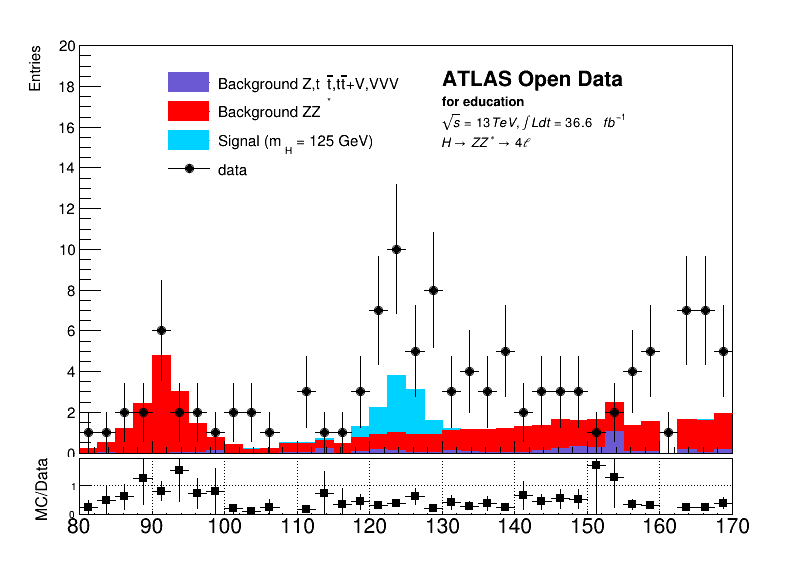

In [18]:
%jsroot off
c = {}
pad1 = {}
pad2 = {}
pad3 = {}
h_sumMC = {}
h_sumDATA = {}

c[hname] = ROOT.TCanvas("c_%s"%hname,"c_%s"%hname,800,600)
c[hname].Draw()


pad1[hname] = ROOT.TPad("pad1","pad1",0.0,0.2,1.0,1.0,21)

pad3[hname] = ROOT.TPad("pad3","pad3",0.0,0.0,1.0,0.2,21)
pad1[hname].SetFillColor(0)

pad3[hname].SetFillColor(0)
pad1[hname].SetRightMargin(0.08)
pad3[hname].SetRightMargin(0.08)

pad1[hname].SetBottomMargin(0.01)

pad3[hname].SetTopMargin(0.01)
pad3[hname].SetBottomMargin(0.5)
pad3[hname].Draw()
pad1[hname].Draw()

pad1[hname].cd()

if hstack[hname].GetNhists():
    hstack[hname].Draw("hist")
    hstack[hname].SetMaximum(20)
    hstack[hname].SetMinimum(0)
    hstack[hname].GetYaxis().SetTitle("Entries")
    hstack[hname].GetXaxis().SetLabelSize(0.0)
    hstack[hname].Draw("hist")
    datastack[hname].Draw("ep same")
elif datastack[hname].GetNhists():
    datastack[hname].Draw("pl")

h_sumMC[hname] = hstack[hname].GetStack().Last().Clone("h_sumMC_%s"%hname)
h_sumDATA[hname] = datastack[hname].GetStack().Last().Clone("h_sumDATA_%s"%hname)
h_sumMC[hname].Divide(h_sumDATA[hname])
h_sumMC[hname].SetMarkerStyle(21)
h_sumMC[hname].SetLineColor(ROOT.kBlack)

pad3[hname].cd()
pad3[hname].SetGridx()
pad3[hname].SetGridy()
h_sumMC[hname].SetTitle("")
h_sumMC[hname].GetXaxis().SetTitleSize(0.2)
h_sumMC[hname].GetXaxis().SetTitleOffset(1.2)
h_sumMC[hname].GetYaxis().SetTitle("MC/Data")
h_sumMC[hname].GetYaxis().SetTitleOffset(0.1)
h_sumMC[hname].GetYaxis().SetTitleSize(0.15)
h_sumMC[hname].GetYaxis().SetTitleOffset(0.2)
h_sumMC[hname].GetYaxis().SetLabelSize(0.1)
h_sumMC[hname].GetXaxis().SetLabelSize(0.2)
h_sumMC[hname].GetXaxis().SetMaxDigits(6);
h_sumMC[hname].GetYaxis().SetNdivisions(2);
h_sumMC[hname].GetYaxis().SetRangeUser(0,2)
h_sumMC[hname].SetMaximum(1.9)
h_sumMC[hname].Draw("ep")

pad1[hname].cd()


pad1[hname].cd()
leg[hname].Draw()

txt1 = ROOT.TLatex()
txt1.SetTextSize(0.05);
# Add text 'ATLAS Open Data' on plot
txt1.DrawLatex(130, 18, "ATLAS Open Data") 
txt1.SetTextSize(0.03);
txt1.DrawLatex(130, 17, "for education") 
txt1.SetTextSize(0.03);
txt1.DrawLatex(130, 16, '\sqrt{s}=13 TeV,\int L dt = '+str(lumi)+'~fb^{-1}')
txt1.SetTextSize(0.03);
txt1.DrawLatex(130, 15, r'H \rightarrow ZZ^* \rightarrow 4\ell') 